In [2]:
!pip install numpy
!pip install torch
!pip install torchvision
!pip install matplotlib
!pip install wandb

In [3]:
!git clone https://github.com/OscarOvanger/GeoDecepticon.git

fatal: destination path 'GeoDecepticon' already exists and is not an empty directory.


In [4]:
import os
os.chdir('/content/GeoDecepticon')

In [5]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import wandb
import os
from tqdm.notebook import tqdm
import copy
from GeneralViT import VisionTransformer, create_model

# Load and plot training data

(9000, 60, 60)


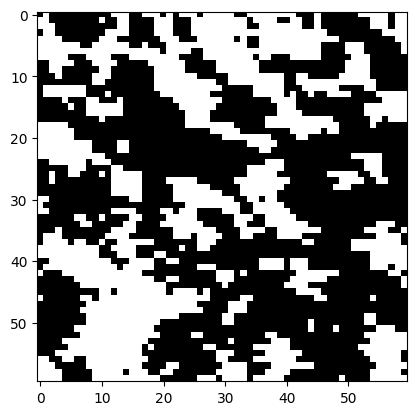

In [6]:
arr = np.load("Data/Markov_field/training_data.npz")["arr_0"]
training_data = arr[:9000]
test_data = arr[9000:]
# We reshape it to 60x60 dataset
training_data = training_data.reshape(-1, 64, 64)
test_data = test_data.reshape(-1, 64, 64)
training_data = training_data[:,:60,:60]
test_data = test_data[:,:60,:60]
print(training_data.shape)
training_data = torch.tensor(training_data,dtype=torch.float32)
test_data = torch.tensor(test_data,dtype=torch.float32)
#plot the first data
plt.imshow(training_data[0],cmap='gray')
plt.show()

In [10]:
# Set model hyperparameters
num_heads = 4
num_layers = 2
ffn_dim = 256
hidden_dim = 128
patch_size = 2

# Initialize the model
model = VisionTransformer(num_heads, num_layers, ffn_dim, hidden_dim)

# Build the vocabulary with 2x2 patches
vocab = model.build_vocabulary(training_data, patch_size=2)

In [12]:
print(model.vocab)

tensor([[0.0000, 0.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 1.0000],
        [0.0000, 1.0000, 1.0000, 1.0000],
        [1.0000, 0.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 0.0000, 0.0000],
        [0.0000, 1.0000, 0.0000, 0.0000],
        [1.0000, 1.0000, 1.0000, 0.0000],
        [0.0000, 1.0000, 1.0000, 0.0000],
        [1.0000, 0.0000, 1.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 0.0000, 1.0000],
        [1.0000, 1.0000, 0.0000, 1.0000],
        [0.0000, 0.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 1.0000, 1.0000],
        [0.5000, 0.5000, 0.5000, 0.5000],
        [0.0000, 0.5000, 0.5000, 0.5000],
        [1.0000, 0.5000, 0.5000, 0.5000],
        [0.5000, 0.0000, 0.5000, 0.5000],
        [0.5000, 1.0000, 0.5000, 0.5000],
        [0.5000, 0.5000, 0.0000, 0.5000],
        [0.5000, 0.5000, 1.0000, 0.5000],
        [0.5000, 0.5000, 0.5000, 0

In [7]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import wandb
from GeneralViT import VisionTransformer, create_model

# Create Binary Image Dataset
class BinaryImageDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]

    @staticmethod
    def image_to_patches(image, patch_size):
        n = image.shape[0]
        patches = torch.zeros((n // patch_size) ** 2, patch_size ** 2, device=image.device)
        idx = 0
        for i in range(0, n, patch_size):
            for j in range(0, n, patch_size):
                patches[idx] = image[i:i+patch_size, j:j+patch_size].reshape(-1)
                idx += 1
        return patches

    @staticmethod
    def patches_to_image(patches, patch_size, image_size):
        image = torch.zeros(image_size, image_size, device=patches.device)
        idx = 0
        for i in range(0, image_size, patch_size):
            for j in range(0, image_size, patch_size):
                image[i:i+patch_size, j:j+patch_size] = patches[idx].reshape(patch_size, patch_size)
                idx += 1
        return image

# Training Pipeline
def train_model(training_data):
    # Set parameters
    num_heads = 4
    num_layers = 2
    ffn_dim = 256
    hidden_dim = 128
    patch_size = 2
    num_epochs = 1000
    batch_size = 32

    # Setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    training_data = training_data.to(device)
    image_size = training_data.shape[1]

    # Initialize model
    model = create_model(training_data, num_heads, num_layers, ffn_dim, hidden_dim, patch_size)
    model = model.to(device)
    # Make sure vocab is also on the correct device
    model.vocab = model.vocab.to(device)

    # Initialize wandb
    wandb.init(project="vision-transformer", config={
        "num_heads": num_heads,
        "num_layers": num_layers,
        "ffn_dim": ffn_dim,
        "hidden_dim": hidden_dim,
        "patch_size": patch_size
    })

    # Initialize optimizer and loss
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    # Initialize dataloader
    dataset = BinaryImageDataset(training_data)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        # Gradually increase masking rate from 15% to 75%
        mask_rate = min(0.75, 0.15 + (0.6 * epoch / num_epochs))
        partial_mask_rate = 0.3  # 30% of masks will be partial masks

        for batch in dataloader:
            batch = batch.to(device)
            batch_size = batch.shape[0]

                            # Convert images to patches
            patches = torch.stack([BinaryImageDataset.image_to_patches(img, patch_size) for img in batch])
            patches = patches.to(device)
            num_patches = patches.shape[1]

            # Create masked patches
            masked_patches = patches.clone()
            mask_indices = torch.zeros(batch_size, num_patches, dtype=torch.bool, device=device)

            # Apply masking
            for b in range(batch_size):
                # Determine patches to mask
                num_to_mask = max(1, int(num_patches * mask_rate))
                mask_idx = torch.randperm(num_patches)[:num_to_mask]
                mask_indices[b, mask_idx] = True

                # Full masks (mask with 0.5s)
                num_partial = int(num_to_mask * partial_mask_rate)
                full_indices = mask_idx[num_partial:]
                if len(full_indices) > 0:
                    masked_patches[b, full_indices] = model.vocab[-1]  # Full mask token

                # Partial masks (keep one observed value)
                for idx in mask_idx[:num_partial]:
                    patch = patches[b, idx].clone()
                    pos_to_keep = torch.randint(0, patch_size**2, (1,)).item()
                    mask = torch.full_like(patch, 0.5)
                    mask[pos_to_keep] = patch[pos_to_keep]
                    masked_patches[b, idx] = mask

            # Forward pass
            logits = model(masked_patches)

            # Calculate targets (closest vocab token for each original patch)
            targets = torch.zeros(batch_size, num_patches, dtype=torch.long, device=device)
            for b in range(batch_size):
                for p in range(num_patches):
                    if mask_indices[b, p]:
                        distances = torch.sum((model.vocab - patches[b, p].unsqueeze(0)) ** 2, dim=1)
                        targets[b, p] = torch.argmin(distances)

            # Calculate loss only on masked patches
            masked_logits = logits[mask_indices]
            masked_targets = targets[mask_indices]
            loss = criterion(masked_logits, masked_targets)

            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Log metrics
        avg_loss = total_loss / len(dataloader)
        wandb.log({"epoch": epoch, "loss": avg_loss, "mask_rate": mask_rate})
        print(f"Epoch {epoch}/{num_epochs}, Loss: {avg_loss:.4f}, Mask Rate: {mask_rate:.2f}")

        # Visualize reconstruction every 20 epochs
        if epoch % 20 == 0 or epoch == num_epochs - 1:
            model.eval()
            with torch.no_grad():
                # Get first image from batch for visualization
                img = next(iter(dataloader))[0].to(device)
                patches = BinaryImageDataset.image_to_patches(img, patch_size).unsqueeze(0).to(device)

                # Create masked version
                masked = patches.clone()
                mask_indices = torch.zeros(1, num_patches, dtype=torch.bool, device=device)

                # Apply same masking logic
                num_to_mask = int(num_patches * mask_rate)
                mask_idx = torch.randperm(num_patches)[:num_to_mask]
                mask_indices[0, mask_idx] = True

                # Full masks
                num_partial = int(num_to_mask * partial_mask_rate)
                masked[0, mask_idx[num_partial:]] = model.vocab[-1]

                # Partial masks
                for idx in mask_idx[:num_partial]:
                    patch = patches[0, idx].clone()
                    pos_to_keep = torch.randint(0, patch_size**2, (1,)).item()
                    mask = torch.full_like(patch, 0.5)
                    mask[pos_to_keep] = patch[pos_to_keep]
                    masked[0, idx] = mask

                # Get predictions
                pred_logits = model(masked)

                # Reconstruct image
                recon = masked.clone()
                for p in range(num_patches):
                    if mask_indices[0, p]:
                        pred_idx = torch.argmax(pred_logits[0, p])
                        pred_patch = model.vocab[pred_idx]

                        # Preserve observed values in partial masks
                        curr = masked[0, p]
                        observed = torch.where(curr != 0.5)[0]
                        if len(observed) > 0:
                            for pos in observed:
                                pred_patch = pred_patch.clone()
                                pred_patch[pos] = curr[pos]

                        recon[0, p] = pred_patch

                # Convert patches back to images
                masked_img = BinaryImageDataset.patches_to_image(masked[0], patch_size, image_size)
                recon_img = BinaryImageDataset.patches_to_image(recon[0], patch_size, image_size)

                # Log images
                wandb.log({
                    "original": wandb.Image(img.cpu()),
                    "masked": wandb.Image(masked_img.cpu()),
                    "reconstructed": wandb.Image(recon_img.cpu())
                }, step=epoch)

    wandb.finish()
    return model

# Example usage
if __name__ == "__main__":
    # Assuming training_data has shape (9000, 64, 64)
    arr = np.load("Data/Markov_field/training_data.npz")["arr_0"]
    training_data = arr[:9000]
    test_data = arr[9000:]
    # We reshape it to 60x60 dataset
    training_data = training_data.reshape(-1, 64, 64)
    test_data = test_data.reshape(-1, 64, 64)
    training_data = training_data[:,:60,:60]
    test_data = test_data[:,:60,:60]
    print(training_data.shape)
    training_data = torch.tensor(training_data,dtype=torch.float32)
    test_data = torch.tensor(test_data,dtype=torch.float32)
    model = train_model(training_data)

(9000, 60, 60)


KeyboardInterrupt: 

In [7]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import wandb
import os
from tqdm.notebook import tqdm
import copy

# Assume VisionTransformer class is defined elsewhere as in your updated model
from transformer_four import VisionTransformer, create_model

# Binary Image Dataset
class BinaryImageDataset(Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx]

# Function to visualize binary images
def plot_binary_image(image, title=None):
    plt.figure(figsize=(5, 5))
    plt.imshow(image.squeeze(), cmap='gray')
    if title:
        plt.title(title)
    plt.axis('off')
    return plt

# Training Pipeline
def train_vision_transformer(
    train_dataset,
    val_dataset=None,
    d_model=512,
    num_heads=8,
    num_layers=6,
    feedforward_dim=2048,
    batch_size=32,
    learning_rate=1e-4,
    num_epochs=1000,
    save_dir="checkpoints",
    condition_indices=None,
    condition_values=None,
    device=None
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    print(f"Using device: {device}")

    # Create directories
    os.makedirs(save_dir, exist_ok=True)

    # Create DataLoader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    if val_dataset:
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Create model
    model = create_model(
        train_dataset,
        d_model=d_model,
        num_heads=num_heads,
        num_layers=num_layers,
        feedforward_dim=feedforward_dim
    ).to(device)

    # Initialize wandb
    wandb.init(
        project="vision-transformer-4x4",
        config={
            "batch_size": batch_size,
            "d_model": d_model,
            "num_heads": num_heads,
            "feedforward_dim": feedforward_dim,
            "num_layers": num_layers,
            "num_tokens": model.num_tokens,
            "num_observed_tokens": model.num_observed_tokens,
            "dropout": 0.1,
            "learning_rate": learning_rate,
            "num_epochs": num_epochs,
        },
    )

    # Optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Track best model
    best_loss = float('inf')
    best_model_state = None

    # Masking rate scheduler - linear increase from 1 to max over epochs
    max_masks = 256  # All patches for a 64x64 image with 4x4 patches

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        # Calculate current masking rate (linear schedule from 1 to max_masks)
        current_max_masks = min(1 + int((max_masks - 1) * epoch / (num_epochs * 0.8)), max_masks)

        # For visualization
        first_batch_imgs = []
        first_batch_masks = []
        first_batch_reconstructions = []

        # Training loop
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}")
        for batch_idx, images in progress_bar:
            batch_size = images.shape[0]

            # Tokenize each image - convert to patches and map to token indices
            # Shape: (batch_size, 256) for 64x64 images with 4x4 patches
            token_indices = torch.stack([
                model.tokenize_image(img) for img in images
            ]).to(device)

            # Create random mask for each image in batch
            # Randomly select number of patches to mask for each image (between 1 and current_max_masks)
            num_masks_per_image = torch.randint(
                1, current_max_masks + 1, (batch_size,)
            ).tolist()

            # Prepare masked tokens and mask tensor
            masked_tokens = token_indices.clone()
            mask = torch.zeros_like(token_indices, dtype=torch.bool)

            # Create masks and apply partial masking for 30% of masked patches
            for b in range(batch_size):
                # Select random positions to mask
                positions_to_mask = torch.randperm(256)[:num_masks_per_image[b]]

                # Determine which positions get partial masks (30%)
                num_partial = int(0.3 * len(positions_to_mask))
                partial_positions = positions_to_mask[:num_partial]
                full_positions = positions_to_mask[num_partial:]

                # Apply full masking (replace with mask token)
                mask[b, full_positions] = True
                masked_tokens[b, full_positions] = model.mask_token_id

                # Apply partial masking (replace with partial mask tokens)
                for i, pos in enumerate(partial_positions):
                    mask[b, pos] = True

                    # Get original token and extract one observed cell
                    orig_token = token_indices[b, pos].item()
                    if orig_token < model.num_observed_tokens:  # Only for non-special tokens
                        # Get the original patch
                        if orig_token in model.token_to_patch:
                            orig_patch = model.token_to_patch[orig_token]

                            # Select a random position to observe (0-15 for 4x4 patch)
                            observed_pos = torch.randint(0, 16, (1,)).item()
                            observed_val = orig_patch[observed_pos].item()

                            # Calculate partial mask token id
                            partial_idx = observed_pos * 2 + int(observed_val)

                            # Assign partial mask token if available
                            if partial_idx < len(model.partial_mask_token_ids):
                                masked_tokens[b, pos] = model.partial_mask_token_ids[partial_idx]
                            else:
                                # Fallback to full mask if no suitable partial token
                                masked_tokens[b, pos] = model.mask_token_id
                        else:
                            masked_tokens[b, pos] = model.mask_token_id
                    else:
                        masked_tokens[b, pos] = model.mask_token_id

            # Forward pass
            logits = model(masked_tokens)

            # Extract only the masked positions for loss calculation
            masked_positions = mask.nonzero(as_tuple=True)
            masked_logits = logits[masked_positions[0], masked_positions[1]]
            masked_targets = token_indices[masked_positions[0], masked_positions[1]]

            # For partial masks, adjust target probabilities to include only compatible tokens
            # For each masked position, we need to filter logits if it's a partial mask
            filtered_logits = []
            filtered_targets = []

            for i in range(len(masked_positions[0])):
                b, pos = masked_positions[0][i], masked_positions[1][i]
                token_id = masked_tokens[b, pos].item()
                target = masked_targets[i].item()

                # If it's a partial mask token
                if token_id in model.partial_mask_token_ids:
                    # Determine which position and value are observed
                    partial_idx = model.partial_mask_token_ids.index(token_id)
                    observed_pos = partial_idx // 2
                    observed_val = partial_idx % 2

                    # Create a mask for compatible tokens (those with the same observed value)
                    compatible_mask = torch.zeros(model.num_tokens)

                    # Find all tokens in vocabulary that have the observed value at observed_pos
                    for t_id, patch in model.token_to_patch.items():
                        if t_id < model.num_observed_tokens and patch[observed_pos].item() == observed_val:
                            compatible_mask[t_id] = 1.0

                    # Zero out logits for incompatible tokens
                    current_logits = logits[b, pos].clone()
                    current_logits = current_logits * compatible_mask.to(device)

                    # Replace very negative values for zeros to maintain softmax stability
                    current_logits[compatible_mask.to(device) == 0] = -1e9

                    filtered_logits.append(current_logits)
                    filtered_targets.append(target)
                else:
                    # For full masks, use all logits
                    filtered_logits.append(logits[b, pos])
                    filtered_targets.append(target)

            # Stack filtered logits and targets
            if filtered_logits:
                filtered_logits = torch.stack(filtered_logits)
                filtered_targets = torch.tensor(filtered_targets).to(device)

                # Compute loss
                loss = criterion(filtered_logits, filtered_targets)

                # Backward and optimize
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

                # Update progress bar
                progress_bar.set_postfix({"loss": loss.item(), "masks": f"{np.mean(num_masks_per_image):.1f}/{current_max_masks}"})
            else:
                # Skip if no masked positions (unlikely, but handle it)
                print("Warning: No masked positions in batch.")
                continue

            # Save first batch for visualization
            if batch_idx == 0:
                with torch.no_grad():
                    # Store original images
                    first_batch_imgs = images[:4].cpu()

                    # Store masked images
                    masked_images = []
                    for i in range(min(4, batch_size)):
                        masked_img = model.tokens_to_image(masked_tokens[i:i+1].cpu())
                        masked_images.append(masked_img.squeeze(0))
                    first_batch_masks = masked_images

                    # Generate reconstructions
                    reconstructed_tokens = masked_tokens[:4].cpu().clone()
                    mask_cpu = mask[:4].cpu()

                    # For each image in mini-batch
                    for i in range(min(4, batch_size)):
                        # Get positions of masked tokens
                        masked_positions_i = mask_cpu[i].nonzero(as_tuple=True)[0]

                        # Get predicted token ids
                        pred_logits = filtered_logits.reshape(-1, model.num_tokens)
                        pred_tokens = torch.argmax(pred_logits, dim=1).cpu()

                        # Count masked positions for this image
                        count = 0
                        for j, pos in enumerate(masked_positions):
                            if pos[0] == i and j < len(pred_tokens):
                                reconstructed_tokens[i, pos[1]] = pred_tokens[count]
                                count += 1

                    # Create reconstructed images
                    reconstructed_images = []
                    for i in range(min(4, batch_size)):
                        recon_img = model.tokens_to_image(reconstructed_tokens[i:i+1])
                        reconstructed_images.append(recon_img.squeeze(0))
                    first_batch_reconstructions = reconstructed_images

        # Calculate average loss for epoch
        avg_loss = total_loss / len(train_loader)

        # Log to wandb
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": avg_loss,
            "masked_patches": np.mean(num_masks_per_image),
            "max_masked_patches": current_max_masks,
        })

        # Visualization every 50 epochs or on the last epoch
        if (epoch + 1) % 50 == 0 or epoch == num_epochs - 1:
            # Log images to wandb
            if first_batch_imgs:
                fig, axes = plt.subplots(3, min(4, batch_size), figsize=(16, 9))
                for i in range(min(4, batch_size)):
                    # Original
                    axes[0, i].imshow(first_batch_imgs[i].squeeze(0), cmap='gray')
                    axes[0, i].set_title(f"Original {i+1}")
                    axes[0, i].axis('off')

                    # Masked
                    axes[1, i].imshow(first_batch_masks[i].squeeze(0), cmap='gray')
                    axes[1, i].set_title(f"Masked {i+1}")
                    axes[1, i].axis('off')

                    # Reconstructed
                    axes[2, i].imshow(first_batch_reconstructions[i].squeeze(0), cmap='gray')
                    axes[2, i].set_title(f"Reconstructed {i+1}")
                    axes[2, i].axis('off')

                plt.tight_layout()
                wandb.log({"sample_images": wandb.Image(plt)})
                plt.close()

        # Validation step
        if val_dataset:
            model.eval()
            val_loss = 0.0

            with torch.no_grad():
                for images in val_loader:
                    # Similar tokenization and masking logic as training
                    token_indices = torch.stack([
                        model.tokenize_image(img) for img in images
                    ]).to(device)

                    # Use fixed masking rate for validation
                    num_masks = min(64, current_max_masks)  # 25% of patches

                    # Prepare masked tokens and mask tensor
                    masked_tokens = token_indices.clone()
                    mask = torch.zeros_like(token_indices, dtype=torch.bool)

                    # Apply masking
                    for b in range(images.shape[0]):
                        positions_to_mask = torch.randperm(256)[:num_masks]
                        mask[b, positions_to_mask] = True
                        masked_tokens[b, positions_to_mask] = model.mask_token_id

                    # Forward pass
                    logits = model(masked_tokens)

                    # Calculate validation loss
                    masked_positions = mask.nonzero(as_tuple=True)
                    masked_logits = logits[masked_positions[0], masked_positions[1]]
                    masked_targets = token_indices[masked_positions[0], masked_positions[1]]

                    # Compute loss
                    batch_loss = criterion(masked_logits, masked_targets)
                    val_loss += batch_loss.item()

            # Calculate average validation loss
            avg_val_loss = val_loss / len(val_loader)
            wandb.log({"val_loss": avg_val_loss})

            # Save best model
            if avg_val_loss < best_loss:
                best_loss = avg_val_loss
                best_model_state = copy.deepcopy(model.state_dict())

                # Save checkpoint
                checkpoint_path = os.path.join(save_dir, f"best_model.pth")
                torch.save({
                    "epoch": epoch + 1,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "loss": avg_val_loss,
                }, checkpoint_path)

                wandb.save(checkpoint_path)
                print(f"New best model saved at epoch {epoch+1} with validation loss: {avg_val_loss:.4f}")

                # Generate samples with conditioning (requirement G)
                if condition_indices is not None and condition_values is not None:
                    generate_conditioned_samples(model, condition_indices, condition_values, device)
        else:
            # If no validation set, save based on training loss
            if avg_loss < best_loss:
                best_loss = avg_loss
                best_model_state = copy.deepcopy(model.state_dict())

                # Save checkpoint
                checkpoint_path = os.path.join(save_dir, f"best_model.pth")
                torch.save({
                    "epoch": epoch + 1,
                    "model_state_dict": model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "loss": avg_loss,
                }, checkpoint_path)

                wandb.save(checkpoint_path)
                print(f"New best model saved at epoch {epoch+1} with training loss: {avg_loss:.4f}")

                # Generate samples with conditioning (requirement G)
                if condition_indices is not None and condition_values is not None:
                    generate_conditioned_samples(model, condition_indices, condition_values, device)

        # Save checkpoint periodically
        if (epoch + 1) % 100 == 0:
            checkpoint_path = os.path.join(save_dir, f"checkpoint_epoch_{epoch+1}.pth")
            torch.save({
                "epoch": epoch + 1,
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "loss": avg_loss,
            }, checkpoint_path)
            wandb.save(checkpoint_path)

    # Finish wandb run
    wandb.finish()

    # Return best model
    if best_model_state:
        model.load_state_dict(best_model_state)

    return model

def generate_conditioned_samples(model, condition_indices, condition_values, device):
    """Generate samples with fixed conditioning values at specified indices"""
    model.eval()

    # Convert to tensor
    condition_indices = torch.tensor(condition_indices, device=device)
    condition_values = torch.tensor(condition_values, device=device)

    # Generate multiple samples with the same conditioning
    num_samples = 3
    samples = []

    with torch.no_grad():
        for i in range(num_samples):
            # Start with all masked tokens
            tokens = torch.full((1, 256), model.mask_token_id, device=device)

            # Set the conditioning values
            for idx, val in zip(condition_indices, condition_values):
                # Convert flat index to 2D patch index
                img_size = 64
                patch_size = 4
                patches_per_row = img_size // patch_size

                pixel_x = idx % img_size
                pixel_y = idx // img_size

                patch_x = pixel_x // patch_size
                patch_y = pixel_y // patch_size

                patch_idx = patch_y * patches_per_row + patch_x

                # Set the conditioning value in the token
                if patch_idx < 256:  # Ensure it's a valid patch index
                    # We need to find a token that has the right value at the right position
                    within_patch_x = pixel_x % patch_size
                    within_patch_y = pixel_y % patch_size
                    within_patch_idx = within_patch_y * patch_size + within_patch_x

                    # Create a partial mask token or find a matching token
                    compatible_tokens = []

                    # Check if we have a partial mask token for this position and value
                    for partial_idx, token_id in enumerate(model.partial_mask_token_ids):
                        if partial_idx // 2 == within_patch_idx and partial_idx % 2 == val.item():
                            # Found a matching partial mask token
                            tokens[0, patch_idx] = token_id
                            break
                    else:
                        # If no partial mask token, find a token with matching value at position
                        for token_id, patch in model.token_to_patch.items():
                            if token_id < model.num_observed_tokens and patch[within_patch_idx].item() == val.item():
                                compatible_tokens.append(token_id)

                        if compatible_tokens:
                            # Randomly select a compatible token
                            tokens[0, patch_idx] = compatible_tokens[torch.randint(0, len(compatible_tokens), (1,)).item()]

            # Now autoregressively generate the rest
            image = model.generate_image(batch_size=1, temperature=0.8, device=device)
            samples.append(image.cpu())

    # Visualize and log the samples
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        axes[i].imshow(samples[i].squeeze(), cmap='gray')
        axes[i].set_title(f"Sample {i+1}")
        axes[i].axis('off')

    plt.tight_layout()
    wandb.log({"conditioned_samples": wandb.Image(plt)})
    plt.close()

    return samples

# Example usage in a notebook:

In [8]:
arr = np.load("Data/Markov_field/training_data.npz")["arr_0"]
training_data = arr[:9000]
test_data = arr[9000:]
training_data = training_data.reshape(-1, 64, 64)
val_data = test_data.reshape(-1, 64, 64)

In [ ]:
# Parameters
d_model = 128
num_heads = 8
num_layers = 4
feedforward_dim = 512
batch_size = 64
learning_rate = 1e-3
num_epochs = 1000

# Load data (example)
train_images = torch.tensor(training_data, dtype=torch.float32)
val_images = torch.tensor(val_data, dtype=torch.float32)

# Create datasets
train_dataset = BinaryImageDataset(train_images)
val_dataset = BinaryImageDataset(val_images)

# Condition indices and values as specified
condition_indices = np.array([876,3825,2122,2892,1556,2683,3667,1767,483,2351,2000,3312,2953,289,2373,2720,872,2713,1206,1341,3541,2226,3423,1904,2882,2540,1497,2524,264,1441])
condition_values = np.array([0,1,1,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,1,1,1,0,1,0,1,1,0,1])

# Train model
model = train_vision_transformer(
    train_dataset,
    val_dataset=None,
    d_model=d_model,
    num_heads=num_heads,
    num_layers=num_layers,
    feedforward_dim=feedforward_dim,
    batch_size=batch_size,
    learning_rate=learning_rate,
    num_epochs=num_epochs,
    condition_indices=condition_indices,
    condition_values=condition_values
)

Using device: cuda
Building vocabulary from training data...
Found 30572 unique patches in training data
Total token vocabulary size: 30605


Epoch 1/1000:   0%|          | 0/141 [00:00<?, ?it/s]

New best model saved at epoch 1 with training loss: 7.3368


Epoch 2/1000:   0%|          | 0/141 [00:00<?, ?it/s]

New best model saved at epoch 2 with training loss: 6.7637


Epoch 3/1000:   0%|          | 0/141 [00:00<?, ?it/s]

New best model saved at epoch 3 with training loss: 6.6008


Epoch 4/1000:   0%|          | 0/141 [00:00<?, ?it/s]

New best model saved at epoch 4 with training loss: 6.5381


Epoch 5/1000:   0%|          | 0/141 [00:00<?, ?it/s]